<a href="https://colab.research.google.com/github/zachhom/170-P3-Neural-Net/blob/Haneul/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writeup

For the writeup, please include the following information:


*   Describe the architecture of your neural network
*   Discuss how you tuned your network and why you think it's performance is reasonable for this task
*   Discuss whether or not you feel that this classifier is appropriate for the given task (check PA3 description)



# PyTorch

## 0 Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Set Hyperparameters

In [ ]:
# You can modify these values

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

## 2. Load Data

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train = True,
  download = True,
  transform = transforms.Compose([
      transforms.ToTensor()                                 
  ]))

train_loader = torch.utils.data.DataLoader(train_set,
                                     batch_size = batch_size_train,
                                     shuffle=True)

train_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train = False,
  download = True,
  transform = transforms.Compose([
      transforms.ToTensor()                                 
  ]))

test_loader = torch.utils.data.DataLoader(train_set,
                                     batch_size = batch_size_train,
                                     shuffle=True)

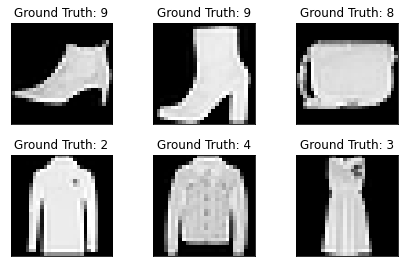

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
INPUT_CHANNELS = example_data.shape[1]
OUTPUT_CLASSES = 10
example_data.shape

torch.Size([64, 1, 28, 28])

## 3. Define Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(INPUT_SHAPE, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, OUTPUT_CLASSES)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
net = Net().to(device)
net

## 4. Train Model

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.MSELoss()

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(net, train_loader, optimizer, epoch)
  test(net, test_loader)

# Tensorflow

## 0. Imports

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

## 1. Set Hyperparameters

In [38]:
# Tune these

n_epochs = 50
batch_size_train = 2500
batch_size_test = 10000
learning_rate = 0.01

## 2. Import Data

In [39]:
(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size_train)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size_test)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## 3. Define Model

In [40]:
model = tf.keras.models.Sequential()

# Convolutional Layers
# model.add(tf.keras.layers.Conv2D(20, (2,2), padding='same', activation='relu', input_shape=(28,28,1)))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(tf.keras.layers.Conv2D(40, (2,2), padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Dense Layers
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(16, activation='relu')) #256
# model.add(tf.keras.layers.Dense(126, activation='relu'))
# model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 7, 7, 32)        

Things to consider:

* dropout, convensation, things like that
* overtrain




## 4. Train Model

In [41]:
model.fit(
    ds_train,
    epochs=n_epochs,
    validation_data=ds_test,
)


Epoch 1/50
24/24 [==============================] - 8s 113ms/step - loss: 0.9823 - sparse_categorical_accuracy: 0.6411 - val_loss: 0.5197 - val_sparse_categorical_accuracy: 0.8127
Epoch 2/50
24/24 [==============================] - 2s 83ms/step - loss: 0.4723 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.3855 - val_sparse_categorical_accuracy: 0.8621
Epoch 3/50
24/24 [==============================] - 2s 81ms/step - loss: 0.3906 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.3355 - val_sparse_categorical_accuracy: 0.8800
Epoch 4/50
24/24 [==============================] - 2s 81ms/step - loss: 0.3539 - sparse_categorical_accuracy: 0.8709 - val_loss: 0.3196 - val_sparse_categorical_accuracy: 0.8863
Epoch 5/50
24/24 [==============================] - 2s 80ms/step - loss: 0.3314 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.2937 - val_sparse_categorical_accuracy: 0.8928
Epoch 6/50
24/24 [==============================] - 2s 81ms/step - loss: 0.3117 - sparse_categorical_acc